In [488]:
#Note this is just for Karthik
import findspark
findspark.init('/home/karthik/spark-3.0.3-bin-hadoop3.2/')

# Milestone 2 (Data Prep)

## Notebook setup

Importation of nessecary libraries and starting spark

In [489]:
from pyspark.sql import SparkSession
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
import geopandas as gpd
import pandas as pd

spark = SparkSession. \
    builder. \
    appName('Milestone4 - Airline Search'). \
    master('spark://karthik-rogstrixg15:7077'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.1-incubating,'
           'org.datasyslab:geotools-wrapper:geotools-24.1'). \
    getOrCreate()

SedonaRegistrator.registerAll(spark)

21/12/08 19:30:05 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
21/12/08 19:30:05 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_pointfromtext replaced a previously registered function.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_polygonfromtext replaced a previously registered function.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_linestringfromtext replaced a previously registered function.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_geomfromtext replaced a previously registered function.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_geomfromwkt replaced a previously registered function.
21/12/08 19:30:05 WARN SimpleFunctionRegistry: The function st_geomfromwkb replaced a previously registered function.
21/12/08 19:30:

True

## Data Collection

Get the data for the boundary of each state in the form of a well-known-text(wkt) polygon representation of all US state-borders as well as the data for the cities of Pullman and Phoenix and their coordinates. 




In [490]:
!wget https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/boundary-each-state.tsv

--2021-12-08 19:30:05--  https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/boundary-each-state.tsv
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60085 (59K) [text/plain]
Saving to: ‘boundary-each-state.tsv.10’

boundary-each-state 100%[===================>]  58.68K  --.-KB/s    in 0.007s  

2021-12-08 19:30:05 (8.77 MB/s) - ‘boundary-each-state.tsv.10’ saved [60085/60085]



In [491]:
!wget https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/cities.csv

--2021-12-08 19:30:05--  https://raw.githubusercontent.com/DataOceanLab/CPTS-415-Project-Examples/main/cities.csv
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60 [text/plain]
Saving to: ‘cities.csv.10’

cities.csv.10       100%[===================>]      60  --.-KB/s    in 0s      

2021-12-08 19:30:05 (1.35 MB/s) - ‘cities.csv.10’ saved [60/60]



## **Load state boundries in WKT TSV and convert WKT string column to a geometry column**



Upload the file containing the boundary for each city by delimiting it by tabspace characters and then convert into dataframe.

In [492]:
states_wkt = spark.read.option("delimiter", "\t").option("header", "false").csv("boundary-each-state.tsv").toDF("s_name","s_bound")
states_wkt.show()
states_wkt.printSchema()

states = states_wkt.selectExpr("s_name", "ST_GeomFromWKT(s_bound) as s_bound")
states.show()
states.printSchema()
states.createOrReplaceTempView("states")

+-------------+--------------------+
|       s_name|             s_bound|
+-------------+--------------------+
|       Alaska|POLYGON((-141.020...|
|      Alabama|POLYGON((-88.1955...|
|     Arkansas|POLYGON((-94.0416...|
|      Arizona|POLYGON((-112.598...|
|   California|POLYGON((-124.400...|
|     Colorado|POLYGON((-109.044...|
|  Connecticut|POLYGON((-73.4875...|
|     Delaware|POLYGON((-75.7919...|
|      Florida|POLYGON((-87.6050...|
|      Georgia|POLYGON((-85.6082...|
|       Hawaii|POLYGON((-154.628...|
|         Iowa|POLYGON((-95.7623...|
|        Idaho|POLYGON((-117.031...|
|     Illinois|POLYGON((-90.6290...|
|      Indiana|POLYGON((-87.5253...|
|       Kansas|POLYGON((-102.050...|
|     Kentucky|POLYGON((-89.5372...|
|    Louisiana|POLYGON((-94.0430...|
|Massachusetts|POLYGON((-72.7789...|
|     Maryland|POLYGON((-79.4778...|
+-------------+--------------------+
only showing top 20 rows

root
 |-- s_name: string (nullable = true)
 |-- s_bound: string (nullable = true)

+--

More data collection

Importation of more data including the airports, airlines and routes

In [493]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

--2021-12-08 19:30:06--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127225 (1.1M) [text/plain]
Saving to: ‘airports.dat.9’

airports.dat.9      100%[===================>]   1.07M  --.-KB/s    in 0.1s    

2021-12-08 19:30:06 (9.89 MB/s) - ‘airports.dat.9’ saved [1127225/1127225]



In [494]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat

--2021-12-08 19:30:06--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396896 (388K) [text/plain]
Saving to: ‘airlines.dat.9’

airlines.dat.9      100%[===================>] 387.59K  --.-KB/s    in 0.04s   

2021-12-08 19:30:06 (10.1 MB/s) - ‘airlines.dat.9’ saved [396896/396896]



Get data about the routes from and to cities.


In [495]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

--2021-12-08 19:30:06--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2377148 (2.3M) [text/plain]
Saving to: ‘routes.dat.9’

routes.dat.9        100%[===================>]   2.27M  11.0MB/s    in 0.2s    

2021-12-08 19:30:07 (11.0 MB/s) - ‘routes.dat.9’ saved [2377148/2377148]



## Data Cleaning
### **Importing airports.dat and perform data cleaning**
Cleaning the data by getting rid of anything unnessecary from the datasets while also turning the raw data into dataframes for further maneuvarability


For  routes.dat there are some null values for either “source airport ID” or “destination airport ID”, We used the 3 letter codes to fill in those IDs from airports.dat
For airport.dat and airline.dat there are also null values for either the alias, the IATA id or the ICAO we replace these values by N/A.

We drop equipment from routes.dat because it is not required in the project description. 
We drop all time zone attributes in airports.dat because those are not in the project description
We drop callsign from airline.dat for the same reason.



In [496]:
airport_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airports.dat").toDF("AirportID","Name"
,"City","Country","IATA","ICAO","Latitude","Longitude","Altitude","Timezone","DST","Database Time Zone","Type","Source")
airport_dat = airport_dat.drop("Source")
airport_dat = airport_dat.drop("Type")
airport_dat = airport_dat.drop("Database Time Zone")
airport_dat = airport_dat.drop("DST")
airport_dat = airport_dat.drop("Timezone")
airport_dat = airport_dat.drop("Altitude")
airport_dat = airport_dat.fillna('N/A')
airport_dat = airport_dat.na.replace("\\N","N/A")
airport_dat = airport_dat.na.replace("-","N/A")

from pyspark.sql import functions
airport = airport_dat.select("AirportID", "Name", "City", "Country","IATA","ICAO",
                                 functions.concat_ws("_",airport_dat.Longitude,airport_dat.Latitude).alias("Location"))

airport = airport.selectExpr("*", "ST_PointFromText(Location, \'_\') as geospacial_Location")
airport = airport.drop("Location")
airport.createOrReplaceTempView("airport")
airport.show()
airport.printSchema()

+---------+--------------------+--------------+----------------+----+----+--------------------+
|AirportID|                Name|          City|         Country|IATA|ICAO| geospacial_Location|
+---------+--------------------+--------------+----------------+----+----+--------------------+
|        1|      Goroka Airport|        Goroka|Papua New Guinea| GKA|AYGA|POINT (145.391998...|
|        2|      Madang Airport|        Madang|Papua New Guinea| MAG|AYMD|POINT (145.789001...|
|        3|Mount Hagen Kagam...|   Mount Hagen|Papua New Guinea| HGU|AYMH|POINT (144.296005...|
|        4|      Nadzab Airport|        Nadzab|Papua New Guinea| LAE|AYNZ|POINT (146.725977...|
|        5|Port Moresby Jack...|  Port Moresby|Papua New Guinea| POM|AYPY|POINT (147.220001...|
|        6|Wewak Internation...|         Wewak|Papua New Guinea| WWK|AYWK|POINT (143.669006...|
|        7|  Narsarsuaq Airport|  Narssarssuaq|       Greenland| UAK|BGBW|POINT (-45.425998...|
|        8|Godthaab / Nuuk A...|      Go

### **Importing airline.dat and perform data cleaning**


In [497]:
airline_dat = spark.read.option("delimiter", ",").option("header", "false").csv("airlines.dat").toDF("AirlineID","Name"
,"Alias","IATA","ICAO","Callsign","Country","Active")
airline_dat = airline_dat.fillna('N/A')
airline_dat = airline_dat.na.replace("\\N","N/A")
airline_dat = airline_dat.na.replace("-","N/A")
airline_dat = airline_dat.drop("Callsign")
airline_dat.createOrReplaceTempView("airline")
airline_dat = spark.sql("select * from airline where AirlineID > 0")
airline_dat.show()
airline_dat.printSchema()
airline = airline_dat

+---------+--------------------+-----+----+----+--------------+------+
|AirlineID|                Name|Alias|IATA|ICAO|       Country|Active|
+---------+--------------------+-----+----+----+--------------+------+
|        1|      Private flight|  N/A| N/A| N/A|           N/A|     Y|
|        2|         135 Airways|  N/A| N/A| GNL| United States|     N|
|        3|       1Time Airline|  N/A|  1T| RNX|  South Africa|     Y|
|        4|2 Sqn No 1 Elemen...|  N/A| N/A| WYT|United Kingdom|     N|
|        5|     213 Flight Unit|  N/A| N/A| TFU|        Russia|     N|
|        6|223 Flight Unit S...|  N/A| N/A| CHD|        Russia|     N|
|        7|   224th Flight Unit|  N/A| N/A| TTF|        Russia|     N|
|        8|         247 Jet Ltd|  N/A| N/A| TWF|United Kingdom|     N|
|        9|         3D Aviation|  N/A| N/A| SEC| United States|     N|
|       10|         40-Mile Air|  N/A|  Q5| MLA| United States|     Y|
|       11|              4D Air|  N/A| N/A| QRT|      Thailand|     N|
|     

### **Importing routes.dat**

In [498]:
route_dat = spark.read.option("delimiter", ",").option("header", "false").csv("routes.dat").toDF("Airline","AirlineID"
,"SourceAirport","SourceAirportID","DestinationAirport","DestinationAirportID","Codeshare","Stops","Equipment")
route_dat = route_dat.drop("Equipment")
route_dat = route_dat.fillna('N/A')
route_dat = route_dat.na.replace("\\N","N/A")
route_dat = route_dat.na.replace("-","N/A")
route_dat.createOrReplaceTempView("route")
#route_dat.show()
#route_dat.printSchema()

route = route_dat
route.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          AER|           2965|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               KZN|                2990|      N/A|    0|
|     2B|      410|          ASF|           2966|               MRV|                2962|      N/A|    0|
|     2B|      410|          CEK|           2968|               KZN|                2990|      N/A|    0|
|     2B|      410|          CEK|           2968|               OVB|                4078|      N/A|    0|
|     2B|      410|          DME|           4029|               KZN|                2990|      N/A|    0|
|     2B|      410|          DME|           40

### **Updating routes table**

In [499]:
airport.count()

7698

In [500]:
airline.count()

6161

In [501]:
route.count()

67663

Here further data cleaning is happening as a new airline_cp variable is introduced which only includes airlines which do not have a blank IATA or ICAO codes. Routes and airports are also cleaned in a similar way into a new route_cp and airport_cp 

# Data transformation: 
We tried to break those tables into 3rd normalization form. For example, in routes.dat, we chose airline ID, source airport ID, destination airport ID to be the primary key. And those attributes are foreign keys 

In [502]:
airline_cp = spark.sql("Select * from airline where airline.IATA != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("IATA","Airline")

In [503]:
route_cp = route.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
            #'r.AirlineID', 'a.AirlineID',
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [504]:
route_cp.count()

78221

In [505]:
airline_cp = spark.sql("Select * from airline where airline.ICAO != 'N/A'")
airline_cp = airline_cp.withColumnRenamed("ICAO","Airline")

In [506]:
route_cp = route_cp.alias('r').join(airline_cp.alias('a'), on = 'Airline', how = 'left')\
    .select('r.Airline', functions.when(~functions.isnull(functions.col('a.AirlineID')),
                                       functions.col('a.AirlineID')
                                       ).otherwise(functions.col('r.AirlineID')).alias('AirlineID'),
           'r.SourceAirport', 'r.SourceAirportID', 'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()


In [507]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","SourceAirport")

In [508]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), 
                                    
                                    on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [509]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","SourceAirport")

In [510]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'SourceAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.SourceAirportID')).alias('SourceAirportID'), 
            'r.DestinationAirport', 'r.DestinationAirportID',
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [511]:
airport_cp = spark.sql("Select * from airport where airport.IATA != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("IATA","DestinationAirport")

In [512]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates()

In [464]:
route_cp.count()

78221

In [465]:
airport_cp = spark.sql("Select * from airport where airport.ICAO != 'N/A'")
airport_cp = airport_cp.withColumnRenamed("ICAO","DestinationAirport")

In [466]:
route_cp = route_cp.alias('r').join(airport_cp.alias('a'), on = 'DestinationAirport', how = 'left')\
    .select('r.Airline', 'r.AirlineID','r.SourceAirport', 'r.SourceAirportID',
            'r.DestinationAirport', functions.when(~functions.isnull(functions.col('a.AirportID')),
                                       functions.col('a.AirportID')
                                       ).otherwise(functions.col('r.DestinationAirportID')).alias('DestinationAirportID'),
           'r.Codeshare', 'r.Stops').dropDuplicates().sort("Airline")

In [467]:
route_cp.show()

+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|Airline|AirlineID|SourceAirport|SourceAirportID|DestinationAirport|DestinationAirportID|Codeshare|Stops|
+-------+---------+-------------+---------------+------------------+--------------------+---------+-----+
|     2B|      410|          NUX|           4364|               SVX|                2975|      N/A|    0|
|     2B|      410|          DME|           4029|               KZN|                2990|      N/A|    0|
|     2B|      410|          KZN|           2990|               CEK|                2968|      N/A|    0|
|     2B|      410|          KZN|           2990|               AER|                2965|      N/A|    0|
|     2B|      410|          KZN|           2990|               ASF|                2966|      N/A|    0|
|     2B|      410|          ASF|           2966|               MRV|                2962|      N/A|    0|
|     2B|      410|          UUA|           61

In [468]:
airport_cp = spark.sql("Select AirportID, Name, City, Country from airport where airport.Country != 'N/A'")
X = input("Enter country's name: ")
airport_cp.filter(airport_cp.Country.rlike(f"(?i)^*{X}$")).show()

+---------+--------------------+-----------------+--------------+
|AirportID|                Name|             City|       Country|
+---------+--------------------+-----------------+--------------+
|      465|Belfast Internati...|          Belfast|United Kingdom|
|      466|   St Angelo Airport|      Enniskillen|United Kingdom|
|      467|George Best Belfa...|          Belfast|United Kingdom|
|      468|City of Derry Air...|      Londonderry|United Kingdom|
|      469|Birmingham Intern...|       Birmingham|United Kingdom|
|      470|    Coventry Airport|         Coventry|United Kingdom|
|      471|   Leicester Airport|        Leicester|United Kingdom|
|      472|Gloucestershire A...|Golouchestershire|United Kingdom|
|      474|Wolverhampton Hal...|  Halfpenny Green|United Kingdom|
|      475|    Cotswold Airport|          Pailton|United Kingdom|
|      476|   Turweston Airport|        Turweston|United Kingdom|
|      477|Wellesbourne Moun...|     Wellesbourne|United Kingdom|
|      478

# Milestone 3 (For Long)

In [469]:
from pyspark.sql.functions import when
route_cp.createOrReplaceTempView("route_cp")
X = input("Enter # stops: ")
newRoute = spark.sql(f"Select AirlineID, Stops from route_cp where route_cp.Stops == {X}")
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")
newRoute = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Stops').dropDuplicates()
newRoute.filter(newRoute.Airline_Name != 'N/A').show()

+---------+------------+-----+
|AirlineID|Airline_Name|Stops|
+---------+------------+-----+
+---------+------------+-----+



In [470]:
newRoute = spark.sql(f"Select AirlineID, Codeshare from route_cp where route_cp.Codeshare == 'Y' \
                     or route_cp.Codeshare == 'y'")
airline_cp = spark.sql(f"Select AirlineID, Name, Alias from airline")
airline_cp = newRoute.alias('r').join(airline_cp.alias('a'), on = 'AirlineID', how = 'inner')\
    .select('r.AirlineID', when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise("a.Alias").alias('Airline_Name'),
'r.Codeshare').dropDuplicates()
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+---------+
|AirlineID|        Airline_Name|Codeshare|
+---------+--------------------+---------+
|     5179|               Tarom|        Y|
|      502|Abu Dhabi Amiri F...|        Y|
|      324|  All Nippon Airways|        Y|
|     2855|              Indigo|        Y|
|     5416|             WestJet|        Y|
|     5347|Virgin Atlantic A...|        Y|
|     1889|       Copa Airlines|        Y|
|     2421|               Flybe|        Y|
|     4559|Swiss Internation...|        Y|
|       28|     Asiana Airlines|        Y|
|     5309|    Vietnam Airlines|        Y|
|     1942|      Cyprus Airways|        Y|
|      137|          Air France|        Y|
|      241|          Air Sahara|        Y|
|     3378|   Malaysia Airlines|        Y|
|     1908|          Corsairfly|        Y|
|     1317|         Air Transat|        Y|
|     4292|    Rwandair Express|        Y|
|      197| Azerbaijan Airlines|        Y|
|     2056|           Dragonair|        Y|
+---------+

In [471]:
airline_cp = spark.sql("""
                       Select AirlineID, Name, Alias, Country, Active 
                       from airline 
                       where Country == 'United States' and (Active == 'Y' or Active == 'y')
                       """)
airline_cp = airline_cp.select(airline_cp.AirlineID, when(airline_cp.Name != 'N/A', airline_cp.Name)
            .otherwise(airline_cp.Alias).alias('Airline_Name'), airline_cp.Country, airline_cp.Active)
airline_cp.filter(airline_cp.Airline_Name != 'N/A').show()

+---------+--------------------+-------------+------+
|AirlineID|        Airline_Name|      Country|Active|
+---------+--------------------+-------------+------+
|       10|         40-Mile Air|United States|     Y|
|       22|      Aloha Airlines|United States|     Y|
|       24|   American Airlines|United States|     Y|
|       35|       Allegiant Air|United States|     Y|
|      109|Alaska Central Ex...|United States|     Y|
|      149|  Air Cargo Carriers|United States|     Y|
|      210|Airlift Internati...|United States|     Y|
|      281|America West Airl...|United States|     Y|
|      282|       Air Wisconsin|United States|     Y|
|      287|Allegheny Commute...|United States|     Y|
|      295|        Air Sunshine|United States|     Y|
|      315|        ATA Airlines|United States|     Y|
|      397|           Arrow Air|United States|     Y|
|      452|Atlantic Southeas...|United States|     Y|
|      659|American Eagle Ai...|United States|     Y|
|      792|          Access 

In [472]:
airport_cp = spark.sql("""
                select Country, count(Country) as Num_Airports
                from airport
                where country != 'N/A'
                group by Country
                order by Num_Airports desc
            """)
airport_cp.first()

Row(Country='United States', Num_Airports=1512)

In [473]:
airline_cp = spark.sql("""
                       Select AirlineID, DestinationAirportID 
                       from route_cp 
                       where AirlineID != 'N/A' and DestinationAirportID != 'N/A'
                       """)
airline_cp.createOrReplaceTempView("airline_cp")
airport_cp = spark.sql("""
                       Select AirportID, City
                       from airport 
                       where City != 'N/A'
                       """)
airport_cp.createOrReplaceTempView("airport_cp")
result = spark.sql("""
            Select airport_cp.City, count(distinct airline_cp.AirlineID) as Num_Airlines
            from airline_cp
            inner join airport_cp
            on airline_cp.DestinationAirportID == airport_cp.AirportID
            group by airport_cp.City
            order by Num_Airlines desc
    """)
topIncomingAirport=result.limit(10)
result.show()

+---------+------------+
|     City|Num_Airlines|
+---------+------------+
|    Paris|         147|
|   London|         139|
|   Moscow|         132|
|  Bangkok|         126|
|Frankfurt|         111|
|     Rome|         103|
| Istanbul|          99|
|Hong Kong|          97|
|    Dubai|          97|
|Singapore|          94|
|Amsterdam|          93|
|   Munich|          93|
|  Beijing|          91|
| New York|          86|
|   Milano|          85|
|Barcelona|          85|
|   Zurich|          83|
|   Vienna|          83|
| Shanghai|          82|
|    Tokyo|          82|
+---------+------------+
only showing top 20 rows



### **For airports.dat, we combine latitude, longitude, altitude into one column called location. Then we make geospatial data from that location column.**

In [474]:
X = input("Enter city's longitude: ")
Y = input("Enter country's latitude: ")

airport_cp = spark.sql("""
    select AirportID,Name,City,Country,geospacial_Location
    from airport
    where City != 'N/A'
""")
airport_cp.createOrReplaceTempView("airport_cp")
result = spark.sql(f" \
    select a.AirportID, a.Name, a.City, a.Country,a.geospacial_Location, ST_Distance(a.geospacial_Location, ST_Point({X}, {Y})) as Distance \
    from airport as a \
    order by Distance")
closestAirport=result.limit(10)
closestAirport2 = gpd.GeoDataFrame(result.limit(100).toPandas(), geometry="geospacial_Location")
result.show()

+---------+--------------------+-------------+-----------+--------------------+------------------+
|AirportID|                Name|         City|    Country| geospacial_Location|          Distance|
+---------+--------------------+-------------+-----------+--------------------+------------------+
|    11979|          Nagurskoye|     Murmansk|     Russia|POINT (47.663586 ...| 36.43990436702935|
|    13416|  Pyramiden Heliport|    Pyramiden|     Norway|POINT (16.337208 ...| 44.50673012830922|
|     7451|        Svea Airport|    Sveagruva|   Svalbard|POINT (16.725 77....| 44.94808675749805|
|      658|Svalbard Airport,...|     Svalbard|     Norway|POINT (15.4656000...| 45.31588994712295|
|    14106| Rogachyovo Air Base|       Belaya|     Russia|POINT (52.4782981...|46.522197085851936|
|     7452|Ny-Ålesund Airpor...|   Ny-Alesund|   Svalbard|POINT (11.8743 78...| 46.80190549698943|
|     4350|    Berlevåg Airport|     Berlevag|     Norway|POINT (29.034201 ...| 46.81542764230614|
|     5589

In [475]:
airportInState = spark.sql("""
    select s.s_name as States, a.AirportID, a.Name, a.City
    from states as s, airport as a
    where ST_Contains(s.s_bound, a.geospacial_Location)
""")
airportInState.show()

+-------------+---------+--------------------+----------------+
|       States|AirportID|                Name|            City|
+-------------+---------+--------------------+----------------+
|       Alaska|     3411|Barter Island LRR...|   Barter Island|
|       Alaska|     3412|Wainwright Air St...| Fort Wainwright|
|       Alaska|     3413|Cape Lisburne LRR...|   Cape Lisburne|
|       Alaska|     3414|Point Lay LRRS Ai...|       Point Lay|
|       Hawaii|     3415|Hilo Internationa...|            Hilo|
|      Florida|     3416|Orlando Executive...|         Orlando|
|       Alaska|     3417|     Bettles Airport|         Bettles|
|       Alaska|     3418|       Clear Airport|      Clear Mews|
|       Alaska|     3419|Indian Mountain L...|Indian Mountains|
|       Alaska|     3420|  Fort Yukon Airport|      Fort Yukon|
|       Alaska|     3421|Sparrevohn LRRS A...|      Sparrevohn|
|       Alaska|     3422|Bryant Army Heliport| Fort Richardson|
|       Alaska|     3423|Tatalina LRRS A

21/12/08 19:29:57 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


In [476]:
airportInState = spark.sql("""
    select s.s_name as States, a.AirportID, a.Name, a.City, s.s_bound
    from states as s, airport as a
    where ST_Contains(s.s_bound, a.geospacial_Location)
""")
geopandas_df = gpd.GeoDataFrame(airportInState.toPandas(), geometry="s_bound")
geopandas_df

21/12/08 19:29:57 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


,States,AirportID,Name,City,s_bound
0,Alaska,3411,Barter Island LRRS Airport,Barter Island,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
1,Alaska,3412,Wainwright Air Station,Fort Wainwright,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
2,Alaska,3413,Cape Lisburne LRRS Airport,Cape Lisburne,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
3,Alaska,3414,Point Lay LRRS Airport,Point Lay,"POLYGON ((-141.02050 70.01870, -141.72910 70.1..."
4,Hawaii,3415,Hilo International Airport,Hilo,"POLYGON ((-154.62840 19.51580, -154.82350 19.8..."
...,...,...,...,...,...
1504,California,13717,Camp Pendleton MCAS (Munn Field) Airport,Oceanside,"POLYGON ((-124.40090 41.99830, -123.62370 42.0..."
1505,Georgia,13757,Vidalia Regional Airport,Vidalia,"POLYGON ((-85.60820 34.99740, -84.72660 34.990..."
1506,Texas,13758,Granbury Regional Airport,Granbury,"POLYGON ((-106.57150 31.86590, -106.50420 31.7..."
1507,New York,13759,Oswego County Airport,Fulton,"POLYGON ((-79.76240 42.51420, -79.06720 42.778..."


# Milestone 4 (Visuals)


## Incoming Airlines Airport


This visualization shows the top 10 cities with the most incoming airlines. (Scroll down to bar chart)

As you can see, the airport in Paris has over 140 airlines servicing it, while the one in Singapore, which is still a top 10 airport, has less than a hundred



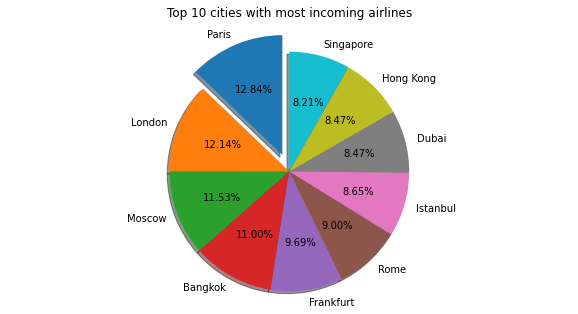

In [477]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

keyList = [x['City'] for x in topIncomingAirport.collect()]
valueList = [x['Num_Airlines'] for x in topIncomingAirport.collect()]
labels = keyList
sizes = valueList

explode = (0.15, 0, 0, 0, 0, 0, 0, 0, 0 ,0) 
plt.rcParams['figure.figsize']=[8,4]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Top 10 cities with most incoming airlines')

plt.show()

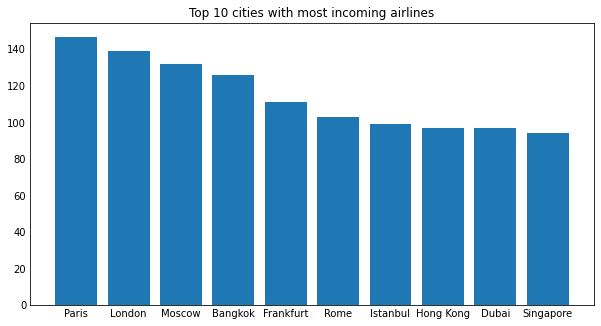

In [478]:
keyList = [x['City'] for x in topIncomingAirport.collect()]
valueList = [x['Num_Airlines'] for x in topIncomingAirport.collect()]
x = keyList
y = valueList
plt.bar(x,y)
plt.title('Top 10 cities with most incoming airlines')
plt.show()

## Find the closest Airports

Our airport search engine also has a function which allows users to find the closest airport to City X based on its geospatial data. Below is an example of several visualizations our airport search engine finding the closest airport to city X, City X can be anything 

(do interactive here, ask the class what City X should be, if interactive fails use base graphs for City X as Beijing)

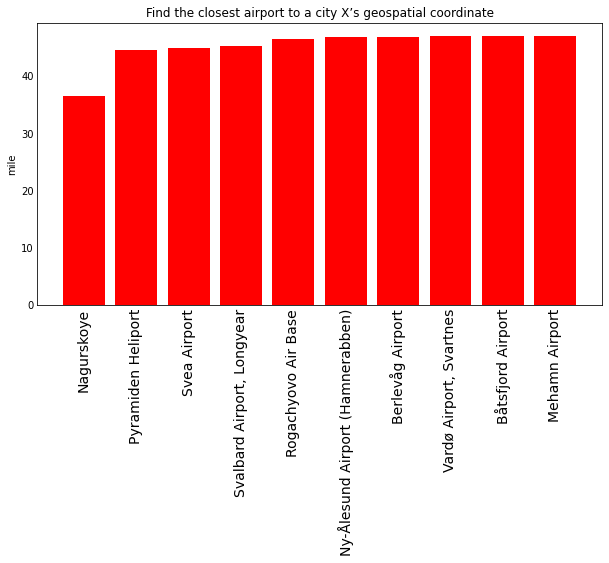

In [479]:
import matplotlib.pyplot as plt
import matplotlib
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.bar(x,y,color='red')
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

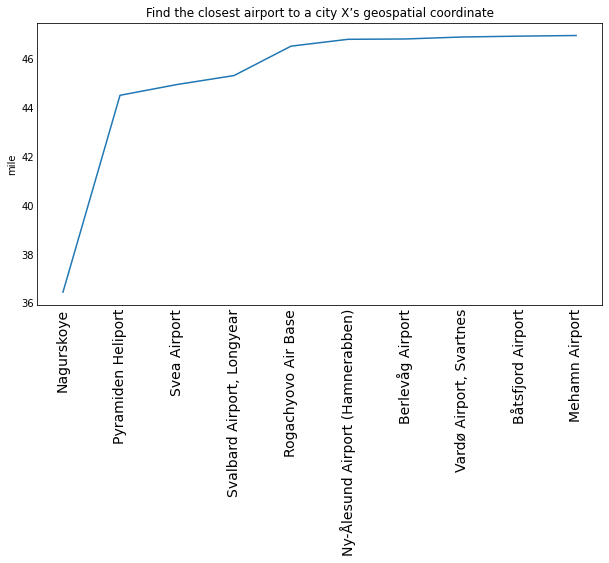

In [480]:
import matplotlib.pyplot as plt
keyList = [x['Name'] for x in closestAirport.collect()]
valueList = [x['Distance'] for x in closestAirport.collect()]
x = keyList
y = valueList
plt.xticks(rotation=90, fontsize=14)
plt.plot(x,y)
plt.ylabel('mile')
plt.title('Find the closest airport to a city X’s geospatial coordinate')
plt.show

<AxesSubplot:>

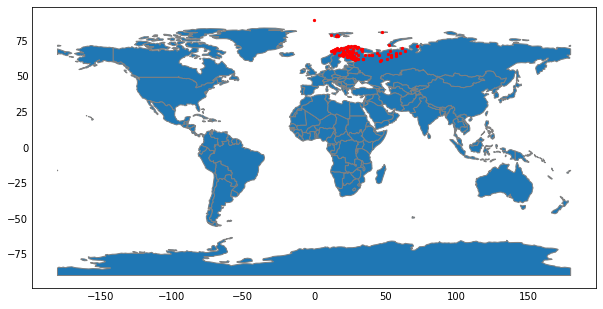

In [481]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(edgecolor='#808080')
closestAirport2.plot(ax=base, marker='o', color='red', markersize=5)

## Airports per state

Finally, our airport search engine can also generate heatmaps to show the number of airports or density of airports per locality. Below is a heatmap showing the number of airports per state

In [482]:
#Creating new states Pandas Dataframe from Spark Dataframe
statesDF = states.toPandas()
statesDF.rename(columns={"s_name":"States"}, inplace=True)
#statesDF = statesDF.set_index('States')
statesDF
#statesDF['States']


,States,s_bound
0,Alaska,"POLYGON ((-141.0205 70.0187, -141.7291 70.1292..."
1,Alabama,"POLYGON ((-88.1955 35.0041, -85.60680000000001..."
2,Arkansas,"POLYGON ((-94.0416 33.0225, -91.20569999999999..."
3,Arizona,"POLYGON ((-112.5989 36.9993, -110.863 37.0004,..."
4,California,"POLYGON ((-124.4009 41.9983, -123.6237 42.0024..."
5,Colorado,"POLYGON ((-109.0448 37.0004, -102.0424 36.9949..."
6,Connecticut,"POLYGON ((-73.4875 42.0498, -73.4247 42.0511, ..."
7,Delaware,"POLYGON ((-75.7919 39.7188, -75.7837 39.521, -..."
8,Florida,"POLYGON ((-87.605 30.9988, -86.5613 30.9964, -..."
9,Georgia,"POLYGON ((-85.6082 34.9974, -84.7266 34.9906, ..."


In [522]:
#Creating Dataframe based on number of airports
AirportCounts = AirportsPerState = geopandas_df['States'].value_counts()

type(AirportCounts)
AirportCounts

Alaska            180
California        114
Texas             100
Florida            87
Georgia            57
North Carolina     42
Michigan           42
New York           39
Kansas             39
Wisconsin          38
Washington         37
Arizona            37
Pennsylvania       36
Ohio               35
South Carolina     31
Colorado           29
Alabama            29
Oklahoma           27
Oregon             26
Illinois           26
Virginia           25
New Mexico         25
Indiana            24
Minnesota          22
Montana            20
Hawaii             19
Missouri           19
Arkansas           19
Mississippi        19
Massachusetts      18
Tennessee          17
Wyoming            17
Kentucky           17
Nebraska           17
Nevada             17
Utah               16
Iowa               16
Louisiana          15
Maine              14
West Virginia      14
Idaho              13
New Jersey         13
Maryland           12
South Dakota       11
North Dakota       11
Connecticu

In [539]:
type(statesDF)
#statesDF = pd.merge(statesDF, AirportCountsDF,on="States", how = "right")
#statesDF.join(AirportCountsDF)
#statesDF
#statesDF

#dgq = statesDF.merge(AirportCounts, left_index=True, right_index=True)
#df.merge(s., )
AirportCountDF = statesDF.set_index('States').merge(AirportCounts, left_index=True, right_index=True)
AirportCountDF.rename(columns={"States":"Airports"}, inplace=True)
AirportCountDF.head()



,s_bound,Airports
Alaska,"POLYGON ((-141.0205 70.0187, -141.7291 70.1292...",180
Alabama,"POLYGON ((-88.1955 35.0041, -85.60680000000001...",29
Arkansas,"POLYGON ((-94.0416 33.0225, -91.20569999999999...",19
Arizona,"POLYGON ((-112.5989 36.9993, -110.863 37.0004,...",37
California,"POLYGON ((-124.4009 41.9983, -123.6237 42.0024...",114


In [549]:
AirportCountGPDF = gpd.GeoDataFrame(AirportCountDF, geometry='s_bound')
#gpd.GeoDataFrame(airportInState.toPandas(), geometry="s_bound")


Text(0.5, 1.0, 'States by number of airports')

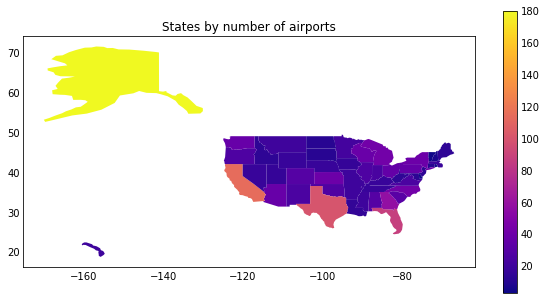

In [564]:
AirportCountGPDF.plot(column='Airports', cmap='plasma', legend=True);
plt.title('States by number of airports')


